# Packages importation 

In [60]:
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [61]:
from Models.BGE_Adam import BGE_Adam
from Models.models import LogisticRegression, SimpleNN, ComplexNN
from Models.training_validation import training_validation, Trainer
from Models.evaluation import evaluate, evaluate_model, evaluate_model_
from Utils.Cross_Validate_Hyperparams import cross_validate_hyperparams, cross_validate_accuracy

# The MNIST database

In [62]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


In [63]:
def load_mnist_images(file_path):
    """Loads MNIST images from a ubyte file."""
    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')  # Magic number
        num_images = int.from_bytes(f.read(4), 'big')    # Number of images 
        num_rows = int.from_bytes(f.read(4), 'big')      # Number of rows per image
        num_cols = int.from_bytes(f.read(4), 'big')      # Number of columns per image
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

In [64]:
def load_mnist_labels(file_path):
    """Loads MNIST labels from a ubyte file."""
    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')  # Magic number
        num_labels = int.from_bytes(f.read(4), 'big')   # Labels number
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

In [65]:
train_images_path = os.path.join(path, "train-images.idx3-ubyte")
train_labels_path = os.path.join(path, "train-labels.idx1-ubyte")
test_images_path = os.path.join(path, "t10k-images.idx3-ubyte")
test_labels_path = os.path.join(path, "t10k-labels.idx1-ubyte")

In [66]:
# Loading the data
X_train = load_mnist_images(train_images_path)
y_train = load_mnist_labels(train_labels_path)
X_test = load_mnist_images(test_images_path)
y_test = load_mnist_labels(test_labels_path)

In [67]:
# Data preprocessing
# Flatten and normalize images
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Convert labels to One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Check new shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (60000, 784), y_train shape: (60000, 10)
X_test shape: (10000, 784), y_test shape: (10000, 10)


In [68]:
# Choose of the ratio for the validation set
validation_ratio = 0.2

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(np.argmax(y_valid, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# Check the shapes
print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_valid shape: {X_valid_tensor.shape}, y_valid shape: {y_valid_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")


X_train shape: torch.Size([48000, 784]), y_train shape: torch.Size([48000])
X_valid shape: torch.Size([12000, 784]), y_valid shape: torch.Size([12000])
X_test shape: torch.Size([10000, 784]), y_test shape: torch.Size([10000])


Without validation dataset:

\#Convert data into PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)  

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

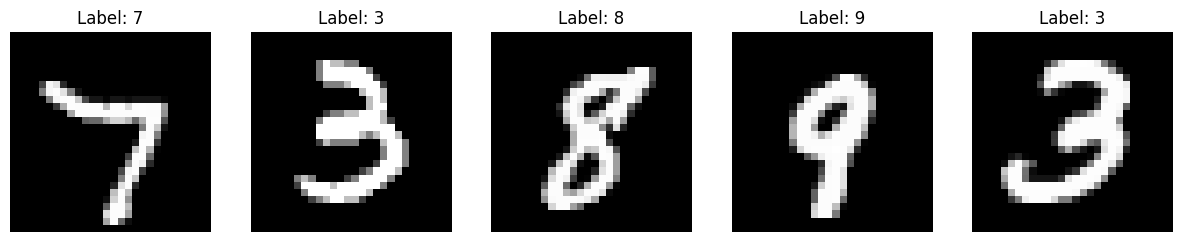

In [69]:
# Visualize some images
def plot_mnist_images(X, y, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = X[i].view(28, 28).detach().numpy()  # Reshape the image to 28x28
        label = y[i].item()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Call the function to plot the images
plot_mnist_images(X_valid_tensor, y_valid_tensor)

In [70]:
print(f"Total number of training examples : {X_train.shape[0]}")
print(f"Total number of validation examples : {X_valid.shape[0]}")
print(f"Total number of test examples : {X_test.shape[0]}")
print(f"Shape of the images : {X_train.shape[1]} (28x28 pixels)")
print(f"Number of classes : {len(torch.unique(y_train_tensor))}")

Total number of training examples : 48000
Total number of validation examples : 12000
Total number of test examples : 10000
Shape of the images : 784 (28x28 pixels)
Number of classes : 10


In [71]:
# Simple statistics on the dataset
print(f"Minimal value of the pixels : {X_train_tensor.min().item()}")
print(f"Maximal value of the pixels : {X_train_tensor.max().item()}")
print(f"Average of the pixels : {X_train_tensor.float().mean().item()}")
print(f"Standard-error of the pixels : {X_train_tensor.float().std().item()}")

Minimal value of the pixels : 0.0
Maximal value of the pixels : 1.0
Average of the pixels : 0.13074526190757751
Standard-error of the pixels : 0.30821332335472107


# Search of the optimal hyperparameters

In [17]:
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

In [18]:
# Combine training and validation for final training
X_combined = torch.cat([X_train_tensor, X_valid_tensor], dim=0)
y_combined = torch.cat([y_train_tensor, y_valid_tensor], dim=0)

In [19]:
models = {
    'LogisticRegression': LogisticRegression,
    'SimpleNN': SimpleNN,
    'ComplexNN': ComplexNN
}

optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

hyperparams = {
    'Adam': [{'lr': 0.001, 'betas': (0.9, 0.999)}, {'lr': 0.0005, 'betas': (0.85, 0.995)}],
    'SGD': [{'lr': 0.01, 'momentum': 0.9}, {'lr': 0.005, 'momentum': 0.95}]
}

# Table 1 : Hyperparameters (cross-entropy loss)
hyperparams_results = {}
with tqdm(total=len(models) * len(optimizers), desc="Global search of the hyperparamèeters") as pbar:
    for model_name, model_class in models.items():
        for opt_name, opt_class in optimizers.items():
            best_params, _ = cross_validate_hyperparams(
                model_class, opt_class, X_combined, y_combined, hyperparams[opt_name], input_dim, num_classes
            )
            hyperparams_results[f'{model_name}_{opt_name}'] = best_params
            pbar.update(1)

# Table 2 : Average accuracy (rate of correct predictions)
accuracy_results = {}
with tqdm(total=len(models) * len(optimizers), desc="Global validation") as pbar:
    for model_name, model_class in models.items():
        for opt_name, opt_class in optimizers.items():
            accuracy = cross_validate_accuracy(
                model_class, opt_class, X_combined, y_combined, hyperparams_results[f'{model_name}_{opt_name}'], input_dim, num_classes
            )
            accuracy_results[f'{model_name}_{opt_name}'] = accuracy
            pbar.update(1)

# Affichage des résultats
print("Table 1 : Hyperparameters")
print(hyperparams_results)
print("\nTable 2 : Average accuracy")
print(accuracy_results)

Global validation: 100%|██████████| 6/6 [07:13<00:00, 72.22s/it]

Table 1 : Hyperparameters
{'LogisticRegression_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'LogisticRegression_SGD': {'lr': 0.01, 'momentum': 0.9}, 'SimpleNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'SimpleNN_SGD': {'lr': 0.01, 'momentum': 0.9}, 'ComplexNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'ComplexNN_SGD': {'lr': 0.01, 'momentum': 0.9}}

Table 2 : Average accuracy
{'LogisticRegression_Adam': 0.6228833377361298, 'LogisticRegression_SGD': 0.6105333268642426, 'SimpleNN_Adam': 0.665666651725769, 'SimpleNN_SGD': 0.26158333420753477, 'ComplexNN_Adam': 0.39226666986942293, 'ComplexNN_SGD': 0.10636666715145111}


In [13]:
hyperparams_results = {'LogisticRegression_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'LogisticRegression_SGD': {'lr': 0.01, 'momentum': 0.9}, 'SimpleNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'SimpleNN_SGD': {'lr': 0.01, 'momentum': 0.9}, 'ComplexNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'ComplexNN_SGD': {'lr': 0.01, 'momentum': 0.9}}
accuracy_results = {'LogisticRegression_Adam': 0.6228833377361298, 'LogisticRegression_SGD': 0.6105333268642426, 'SimpleNN_Adam': 0.665666651725769, 'SimpleNN_SGD': 0.26158333420753477, 'ComplexNN_Adam': 0.39226666986942293, 'ComplexNN_SGD': 0.10636666715145111}

# Logistic regression

## BGE-Adam optimizer

In [18]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = LogisticRegression(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/120, Train Loss: 0.3754, Val Loss: 0.3279, Val Accuracy: 0.9107
Epoch 2/120, Train Loss: 0.3216, Val Loss: 0.3106, Val Accuracy: 0.9219
Epoch 3/120, Train Loss: 0.3198, Val Loss: 0.3299, Val Accuracy: 0.9169
Epoch 4/120, Train Loss: 0.3148, Val Loss: 0.3750, Val Accuracy: 0.9050
Epoch 5/120, Train Loss: 0.3185, Val Loss: 0.3398, Val Accuracy: 0.9177
Epoch 6/120, Train Loss: 0.3158, Val Loss: 0.3409, Val Accuracy: 0.9187
Epoch 7/120, Train Loss: 0.3136, Val Loss: 0.3544, Val Accuracy: 0.9169
Epoch 8/120, Train Loss: 0.3155, Val Loss: 0.3797, Val Accuracy: 0.9087
Epoch 9/120, Train Loss: 0.3167, Val Loss: 0.3653, Val Accuracy: 0.9183
Epoch 10/120, Train Loss: 0.3168, Val Loss: 0.3720, Val Accuracy: 0.9168
Epoch 11/120, Train Loss: 0.3174, Val Loss: 0.3650, Val Accuracy: 0.9148
Epoch 12/120, Train Loss: 0.3171, Val Loss: 0.3619, Val Accuracy: 0.9195
Epoch 13/120, Train Loss: 0.3169, Val Loss: 0.3753, Val Accuracy: 0.9144
Epoch 14/120, Train Loss: 0.3181, Val Loss: 0.3752, Val Accu

In [34]:
# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Test Accuracy: 0.9143
Test Precision: 0.9146
Test Recall: 0.9143
Test F1 Score: 0.9143


In [35]:
evaluate(model, X_test_tensor, y_test_tensor)

0.9143000245094299

## Adam optimizer

In [58]:
# Initializing the model, optimizer and loss function
model = LogisticRegression(input_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/120, Train Loss: 0.5908, Val Loss: 0.3658, Val Accuracy: 0.9026
Epoch 2/120, Train Loss: 0.3385, Val Loss: 0.3199, Val Accuracy: 0.9107
Epoch 3/120, Train Loss: 0.3058, Val Loss: 0.2968, Val Accuracy: 0.9174
Epoch 4/120, Train Loss: 0.2893, Val Loss: 0.2872, Val Accuracy: 0.9194
Epoch 5/120, Train Loss: 0.2799, Val Loss: 0.2822, Val Accuracy: 0.9206
Epoch 6/120, Train Loss: 0.2728, Val Loss: 0.2806, Val Accuracy: 0.9226
Epoch 7/120, Train Loss: 0.2679, Val Loss: 0.2791, Val Accuracy: 0.9222
Epoch 8/120, Train Loss: 0.2638, Val Loss: 0.2773, Val Accuracy: 0.9238
Epoch 9/120, Train Loss: 0.2600, Val Loss: 0.2738, Val Accuracy: 0.9234
Epoch 10/120, Train Loss: 0.2575, Val Loss: 0.2737, Val Accuracy: 0.9250
Epoch 11/120, Train Loss: 0.2551, Val Loss: 0.2724, Val Accuracy: 0.9244
Epoch 12/120, Train Loss: 0.2529, Val Loss: 0.2736, Val Accuracy: 0.9246
Epoch 13/120, Train Loss: 0.2507, Val Loss: 0.2706, Val Accuracy: 0.9263
Epoch 14/120, Train Loss: 0.2491, Val Loss: 0.2712, Val Accu

## SGD optimizer

In [59]:
# Initializing the model, optimizer and loss function
model = LogisticRegression(input_dim, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/120, Train Loss: 0.5137, Val Loss: 0.3643, Val Accuracy: 0.8998
Epoch 2/120, Train Loss: 0.3484, Val Loss: 0.3281, Val Accuracy: 0.9112
Epoch 3/120, Train Loss: 0.3231, Val Loss: 0.3133, Val Accuracy: 0.9140
Epoch 4/120, Train Loss: 0.3102, Val Loss: 0.3061, Val Accuracy: 0.9172
Epoch 5/120, Train Loss: 0.3007, Val Loss: 0.2996, Val Accuracy: 0.9170
Epoch 6/120, Train Loss: 0.2945, Val Loss: 0.2965, Val Accuracy: 0.9175
Epoch 7/120, Train Loss: 0.2895, Val Loss: 0.2927, Val Accuracy: 0.9190
Epoch 8/120, Train Loss: 0.2853, Val Loss: 0.2914, Val Accuracy: 0.9187
Epoch 9/120, Train Loss: 0.2822, Val Loss: 0.2880, Val Accuracy: 0.9193
Epoch 10/120, Train Loss: 0.2792, Val Loss: 0.2865, Val Accuracy: 0.9197
Epoch 11/120, Train Loss: 0.2770, Val Loss: 0.2872, Val Accuracy: 0.9197
Epoch 12/120, Train Loss: 0.2747, Val Loss: 0.2853, Val Accuracy: 0.9218
Epoch 13/120, Train Loss: 0.2731, Val Loss: 0.2832, Val Accuracy: 0.9218
Epoch 14/120, Train Loss: 0.2712, Val Loss: 0.2835, Val Accu

## Comparison of optimizers


Running SGD optimizer...
Epoch 12/120, Train Loss: 0.2746, Val Loss: 0.2857, Val Accuracy: 0.9208
Epoch 24/120, Train Loss: 0.2599, Val Loss: 0.2803, Val Accuracy: 0.9204
Epoch 36/120, Train Loss: 0.2524, Val Loss: 0.2780, Val Accuracy: 0.9236
Epoch 48/120, Train Loss: 0.2479, Val Loss: 0.2799, Val Accuracy: 0.9231
Epoch 60/120, Train Loss: 0.2441, Val Loss: 0.2784, Val Accuracy: 0.9248
Epoch 72/120, Train Loss: 0.2410, Val Loss: 0.2802, Val Accuracy: 0.9220
Epoch 84/120, Train Loss: 0.2393, Val Loss: 0.2786, Val Accuracy: 0.9245
Epoch 96/120, Train Loss: 0.2371, Val Loss: 0.2801, Val Accuracy: 0.9233
Epoch 108/120, Train Loss: 0.2359, Val Loss: 0.2803, Val Accuracy: 0.9239
Epoch 120/120, Train Loss: 0.2343, Val Loss: 0.2825, Val Accuracy: 0.9232

Running Adam optimizer...
Epoch 12/120, Train Loss: 0.2530, Val Loss: 0.2711, Val Accuracy: 0.9271
Epoch 24/120, Train Loss: 0.2381, Val Loss: 0.2721, Val Accuracy: 0.9266
Epoch 36/120, Train Loss: 0.2314, Val Loss: 0.2736, Val Accuracy: 0.9

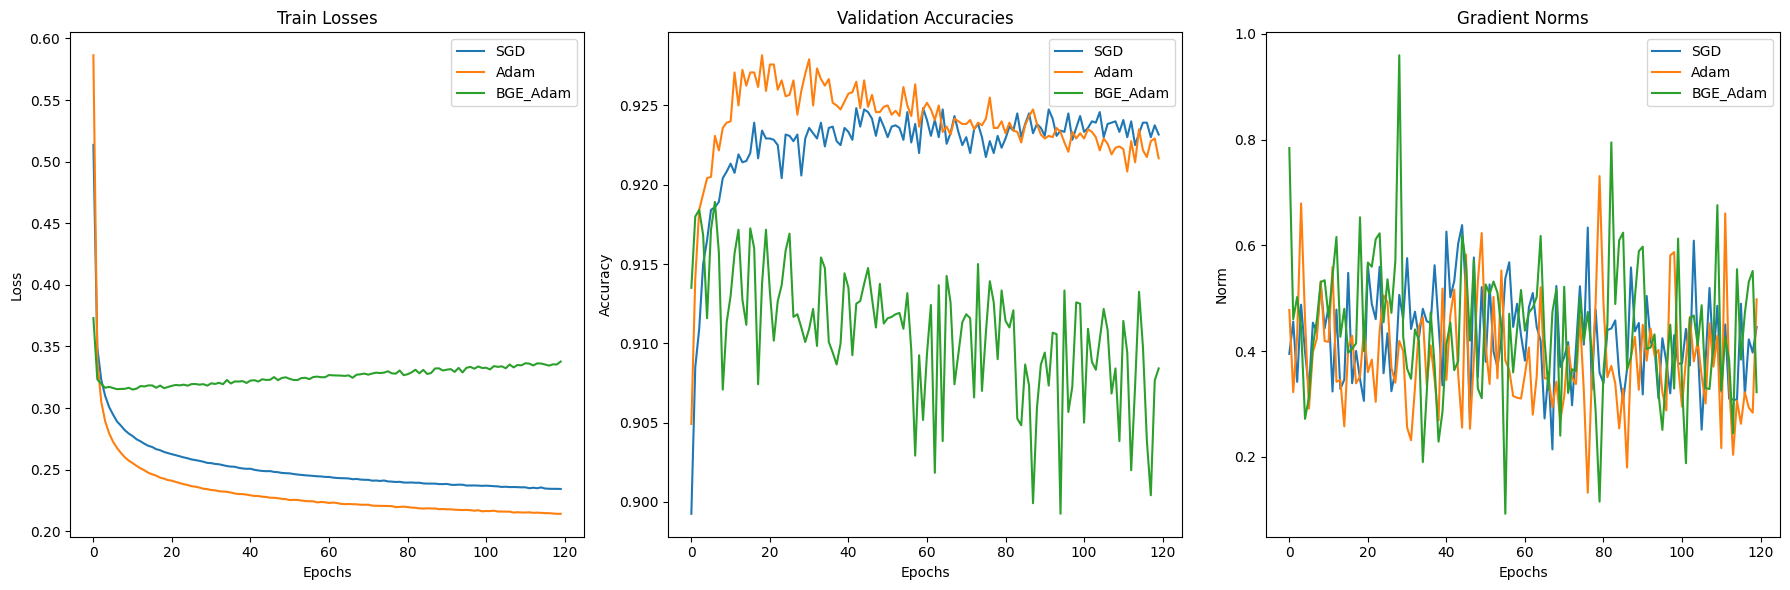

In [41]:
# Données
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=LogisticRegression,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=120,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Simple neural network

## BGE-Adam optimizer

In [42]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = SimpleNN(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

In [43]:
# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/120, Train Loss: 0.2603, Val Loss: 0.1645, Val Accuracy: 0.9551
Epoch 2/120, Train Loss: 0.1550, Val Loss: 0.2180, Val Accuracy: 0.9439
Epoch 3/120, Train Loss: 0.1358, Val Loss: 0.1657, Val Accuracy: 0.9598
Epoch 4/120, Train Loss: 0.1209, Val Loss: 0.1729, Val Accuracy: 0.9631
Epoch 5/120, Train Loss: 0.1119, Val Loss: 0.2318, Val Accuracy: 0.9620
Epoch 6/120, Train Loss: 0.1048, Val Loss: 0.2152, Val Accuracy: 0.9632
Epoch 7/120, Train Loss: 0.1036, Val Loss: 0.2226, Val Accuracy: 0.9669
Epoch 8/120, Train Loss: 0.0940, Val Loss: 0.2542, Val Accuracy: 0.9664
Epoch 9/120, Train Loss: 0.0919, Val Loss: 0.2725, Val Accuracy: 0.9657
Epoch 10/120, Train Loss: 0.0854, Val Loss: 0.2917, Val Accuracy: 0.9683
Epoch 11/120, Train Loss: 0.0854, Val Loss: 0.2897, Val Accuracy: 0.9678
Epoch 12/120, Train Loss: 0.0768, Val Loss: 0.3023, Val Accuracy: 0.9681
Epoch 13/120, Train Loss: 0.0767, Val Loss: 0.3667, Val Accuracy: 0.9641
Epoch 14/120, Train Loss: 0.0680, Val Loss: 0.3064, Val Accu

## Adam optimizer

In [47]:
# Initializing the model, optimizer and loss function
model = SimpleNN(input_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/120, Train Loss: 0.4279, Val Loss: 0.2468, Val Accuracy: 0.9299
Epoch 2/120, Train Loss: 0.2132, Val Loss: 0.1887, Val Accuracy: 0.9472
Epoch 3/120, Train Loss: 0.1658, Val Loss: 0.1590, Val Accuracy: 0.9546
Epoch 4/120, Train Loss: 0.1351, Val Loss: 0.1379, Val Accuracy: 0.9589
Epoch 5/120, Train Loss: 0.1139, Val Loss: 0.1268, Val Accuracy: 0.9628
Epoch 6/120, Train Loss: 0.0972, Val Loss: 0.1147, Val Accuracy: 0.9671
Epoch 7/120, Train Loss: 0.0842, Val Loss: 0.1048, Val Accuracy: 0.9705
Epoch 8/120, Train Loss: 0.0734, Val Loss: 0.1036, Val Accuracy: 0.9705
Epoch 9/120, Train Loss: 0.0640, Val Loss: 0.0987, Val Accuracy: 0.9728
Epoch 10/120, Train Loss: 0.0564, Val Loss: 0.0957, Val Accuracy: 0.9723
Epoch 11/120, Train Loss: 0.0497, Val Loss: 0.0933, Val Accuracy: 0.9732
Epoch 12/120, Train Loss: 0.0450, Val Loss: 0.0974, Val Accuracy: 0.9722
Epoch 13/120, Train Loss: 0.0400, Val Loss: 0.0939, Val Accuracy: 0.9734
Epoch 14/120, Train Loss: 0.0356, Val Loss: 0.0948, Val Accu

## SGD optimizer

In [48]:
# Initializing the model, optimizer and loss function
model = SimpleNN(input_dim, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/120, Train Loss: 0.5134, Val Loss: 0.3032, Val Accuracy: 0.9145
Epoch 2/120, Train Loss: 0.2652, Val Loss: 0.2370, Val Accuracy: 0.9334
Epoch 3/120, Train Loss: 0.2085, Val Loss: 0.2017, Val Accuracy: 0.9434
Epoch 4/120, Train Loss: 0.1713, Val Loss: 0.1690, Val Accuracy: 0.9520
Epoch 5/120, Train Loss: 0.1458, Val Loss: 0.1547, Val Accuracy: 0.9547
Epoch 6/120, Train Loss: 0.1272, Val Loss: 0.1408, Val Accuracy: 0.9589
Epoch 7/120, Train Loss: 0.1131, Val Loss: 0.1325, Val Accuracy: 0.9626
Epoch 8/120, Train Loss: 0.1019, Val Loss: 0.1199, Val Accuracy: 0.9647
Epoch 9/120, Train Loss: 0.0930, Val Loss: 0.1166, Val Accuracy: 0.9656
Epoch 10/120, Train Loss: 0.0841, Val Loss: 0.1090, Val Accuracy: 0.9678
Epoch 11/120, Train Loss: 0.0779, Val Loss: 0.1086, Val Accuracy: 0.9679
Epoch 12/120, Train Loss: 0.0716, Val Loss: 0.1040, Val Accuracy: 0.9688
Epoch 13/120, Train Loss: 0.0658, Val Loss: 0.1018, Val Accuracy: 0.9697
Epoch 14/120, Train Loss: 0.0612, Val Loss: 0.1031, Val Accu

## Comparison of optimizers


Running SGD optimizer...
Epoch 12/120, Train Loss: 0.0715, Val Loss: 0.1040, Val Accuracy: 0.9695
Epoch 24/120, Train Loss: 0.0320, Val Loss: 0.0951, Val Accuracy: 0.9716
Epoch 36/120, Train Loss: 0.0164, Val Loss: 0.0908, Val Accuracy: 0.9745
Epoch 48/120, Train Loss: 0.0090, Val Loss: 0.0958, Val Accuracy: 0.9750
Epoch 60/120, Train Loss: 0.0056, Val Loss: 0.0992, Val Accuracy: 0.9758
Epoch 72/120, Train Loss: 0.0039, Val Loss: 0.1023, Val Accuracy: 0.9754
Epoch 84/120, Train Loss: 0.0029, Val Loss: 0.1057, Val Accuracy: 0.9763
Epoch 96/120, Train Loss: 0.0023, Val Loss: 0.1069, Val Accuracy: 0.9765
Epoch 108/120, Train Loss: 0.0019, Val Loss: 0.1102, Val Accuracy: 0.9762
Epoch 120/120, Train Loss: 0.0016, Val Loss: 0.1128, Val Accuracy: 0.9756

Running Adam optimizer...
Epoch 12/120, Train Loss: 0.0469, Val Loss: 0.1039, Val Accuracy: 0.9692
Epoch 24/120, Train Loss: 0.0124, Val Loss: 0.1146, Val Accuracy: 0.9730
Epoch 36/120, Train Loss: 0.0046, Val Loss: 0.1462, Val Accuracy: 0.9

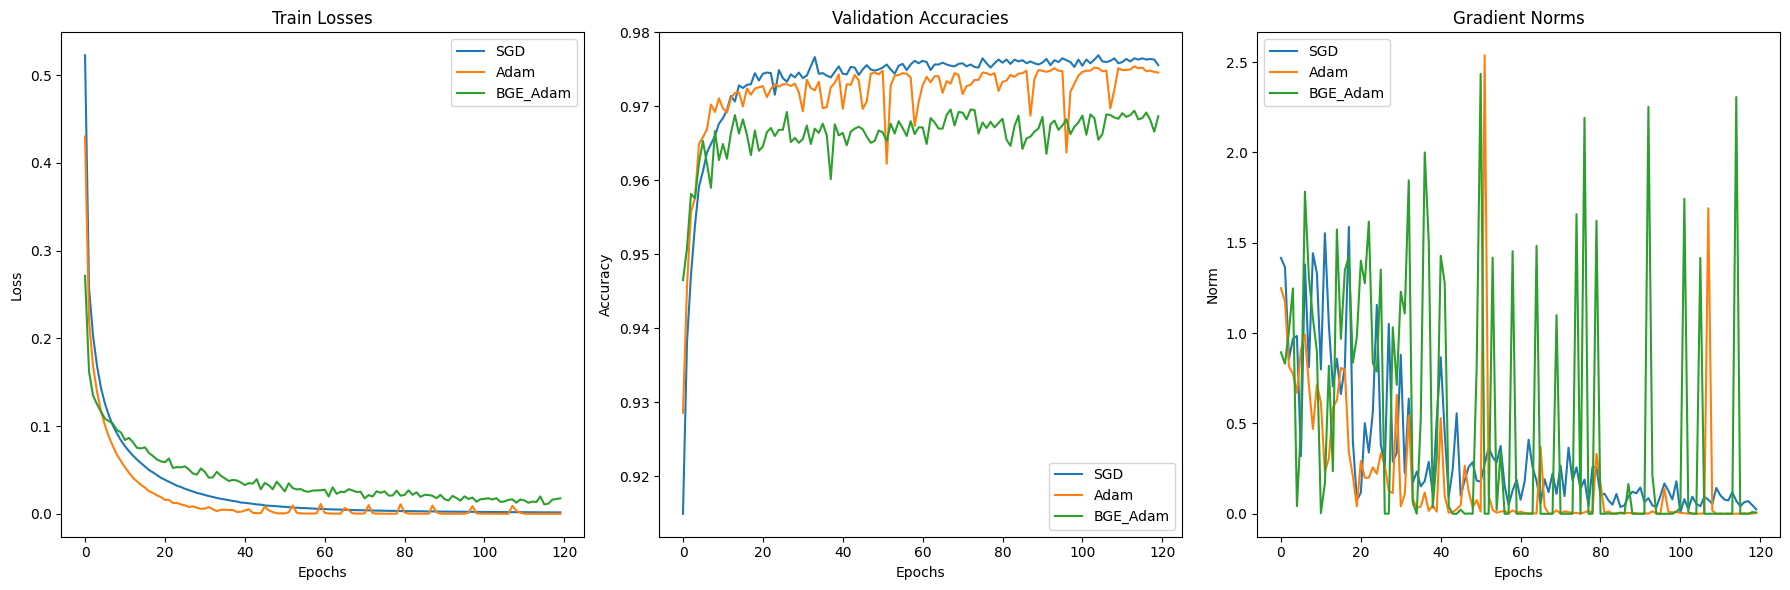

In [49]:
# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=SimpleNN,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=120,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Complex neural network

## BGE-Adam optimizer

In [72]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = ComplexNN(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

In [74]:
# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

Epoch 1/120, Train Loss: 0.6996, Val Loss: 0.5440, Val Accuracy: 0.9373
Epoch 2/120, Train Loss: 0.7020, Val Loss: 0.5887, Val Accuracy: 0.9362
Epoch 3/120, Train Loss: 0.7029, Val Loss: 0.5274, Val Accuracy: 0.9394
Epoch 4/120, Train Loss: 0.6461, Val Loss: 0.5767, Val Accuracy: 0.9352
Epoch 5/120, Train Loss: 0.7223, Val Loss: 0.5064, Val Accuracy: 0.9367
Epoch 6/120, Train Loss: 0.6945, Val Loss: 0.4679, Val Accuracy: 0.9359
Epoch 7/120, Train Loss: 0.6704, Val Loss: 0.7134, Val Accuracy: 0.9352
Epoch 8/120, Train Loss: 0.7203, Val Loss: 0.6315, Val Accuracy: 0.9371
Epoch 9/120, Train Loss: 0.7045, Val Loss: 0.5960, Val Accuracy: 0.9352
Epoch 10/120, Train Loss: 0.7663, Val Loss: 0.5202, Val Accuracy: 0.9395
Epoch 11/120, Train Loss: 0.7017, Val Loss: 0.5048, Val Accuracy: 0.9382
Epoch 12/120, Train Loss: 0.7135, Val Loss: 0.6095, Val Accuracy: 0.9378
Epoch 13/120, Train Loss: 0.7492, Val Loss: 0.5318, Val Accuracy: 0.9388
Epoch 14/120, Train Loss: 0.7551, Val Loss: 0.5645, Val Accu

In [79]:
# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Test Accuracy: 0.9302
Test Precision: 0.9335
Test Recall: 0.9302
Test F1 Score: 0.9307


## Adam optimizer

In [51]:
# Initializing the model, optimizer and loss function
model = ComplexNN(input_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Epoch 1/120, Train Loss: 0.7136, Val Loss: 0.2514, Val Accuracy: 0.9263
Epoch 2/120, Train Loss: 0.3527, Val Loss: 0.1821, Val Accuracy: 0.9469
Epoch 3/120, Train Loss: 0.2921, Val Loss: 0.1597, Val Accuracy: 0.9537
Epoch 4/120, Train Loss: 0.2542, Val Loss: 0.1467, Val Accuracy: 0.9572
Epoch 5/120, Train Loss: 0.2352, Val Loss: 0.1321, Val Accuracy: 0.9609
Epoch 6/120, Train Loss: 0.2222, Val Loss: 0.1274, Val Accuracy: 0.9625
Epoch 7/120, Train Loss: 0.2082, Val Loss: 0.1251, Val Accuracy: 0.9633
Epoch 8/120, Train Loss: 0.1985, Val Loss: 0.1202, Val Accuracy: 0.9635
Epoch 9/120, Train Loss: 0.1939, Val Loss: 0.1135, Val Accuracy: 0.9661
Epoch 10/120, Train Loss: 0.1832, Val Loss: 0.1134, Val Accuracy: 0.9680
Epoch 11/120, Train Loss: 0.1782, Val Loss: 0.1086, Val Accuracy: 0.9689
Epoch 12/120, Train Loss: 0.1762, Val Loss: 0.1125, Val Accuracy: 0.9671
Epoch 13/120, Train Loss: 0.1706, Val Loss: 0.1083, Val Accuracy: 0.9682
Epoch 14/120, Train Loss: 0.1709, Val Loss: 0.1070, Val Accu

## SGD optimizer

In [54]:
# Initializing the model, optimizer and loss function
model = ComplexNN(input_dim, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=120, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

Epoch 1/120, Train Loss: 1.1370, Val Loss: 0.3385, Val Accuracy: 0.9003
Epoch 2/120, Train Loss: 0.4407, Val Loss: 0.2227, Val Accuracy: 0.9369
Epoch 3/120, Train Loss: 0.3411, Val Loss: 0.1900, Val Accuracy: 0.9454
Epoch 4/120, Train Loss: 0.3012, Val Loss: 0.1656, Val Accuracy: 0.9525
Epoch 5/120, Train Loss: 0.2680, Val Loss: 0.1475, Val Accuracy: 0.9575
Epoch 6/120, Train Loss: 0.2483, Val Loss: 0.1475, Val Accuracy: 0.9575
Epoch 7/120, Train Loss: 0.2415, Val Loss: 0.1371, Val Accuracy: 0.9597
Epoch 8/120, Train Loss: 0.2288, Val Loss: 0.1289, Val Accuracy: 0.9625
Epoch 9/120, Train Loss: 0.2207, Val Loss: 0.1261, Val Accuracy: 0.9625
Epoch 10/120, Train Loss: 0.2078, Val Loss: 0.1266, Val Accuracy: 0.9632
Epoch 11/120, Train Loss: 0.2011, Val Loss: 0.1141, Val Accuracy: 0.9650
Epoch 12/120, Train Loss: 0.2001, Val Loss: 0.1206, Val Accuracy: 0.9653
Epoch 13/120, Train Loss: 0.1850, Val Loss: 0.1153, Val Accuracy: 0.9672
Epoch 14/120, Train Loss: 0.1894, Val Loss: 0.1122, Val Accu

In [56]:
# Evaluate the model on the test set
accuracy, precision, recall, f1_score = evaluate_model_(model, X_test_tensor, y_test_tensor)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Test Accuracy: 0.9745
Test Precision: 0.9746
Test Recall: 0.9745
Test F1 Score: 0.9745


## Comparison optimizers


Running SGD optimizer...
Epoch 12/120, Train Loss: 0.1992, Val Loss: 0.1151, Val Accuracy: 0.9660
Epoch 24/120, Train Loss: 0.1576, Val Loss: 0.1064, Val Accuracy: 0.9713
Epoch 36/120, Train Loss: 0.1350, Val Loss: 0.1001, Val Accuracy: 0.9715
Epoch 48/120, Train Loss: 0.1284, Val Loss: 0.0986, Val Accuracy: 0.9732
Epoch 60/120, Train Loss: 0.1128, Val Loss: 0.0984, Val Accuracy: 0.9724
Epoch 72/120, Train Loss: 0.1121, Val Loss: 0.0977, Val Accuracy: 0.9732
Epoch 84/120, Train Loss: 0.1057, Val Loss: 0.0993, Val Accuracy: 0.9721
Epoch 96/120, Train Loss: 0.0985, Val Loss: 0.1013, Val Accuracy: 0.9738
Epoch 108/120, Train Loss: 0.0952, Val Loss: 0.1013, Val Accuracy: 0.9730
Epoch 120/120, Train Loss: 0.0897, Val Loss: 0.1066, Val Accuracy: 0.9736

Running Adam optimizer...
Epoch 12/120, Train Loss: 0.1786, Val Loss: 0.1124, Val Accuracy: 0.9674
Epoch 24/120, Train Loss: 0.1452, Val Loss: 0.1072, Val Accuracy: 0.9691
Epoch 36/120, Train Loss: 0.1292, Val Loss: 0.1034, Val Accuracy: 0.9

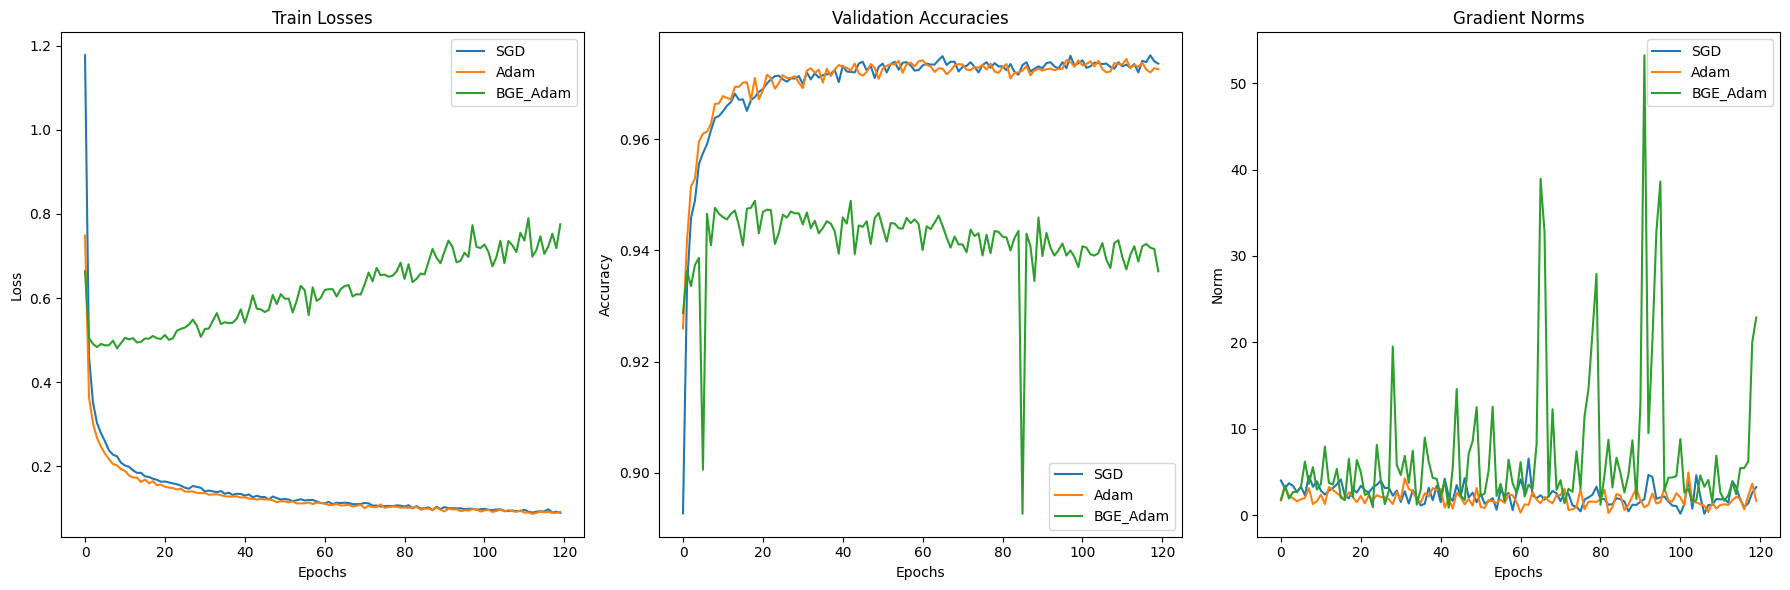

In [57]:
# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=ComplexNN,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=120,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)